In [1]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, remove_noise_satellite


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_raw, dataset_raw)

In [2]:
# haal dataset op waar je molens kan zien
dataset_raw = rasterio.open("./data/crs-2.tiff")
img_raw = dataset_raw.read(1)
block_size = 30

In [3]:
from cv2 import cv2 as cv

# haal dataset op waar we kunnen afleiden of we land of water zien
dataset_land = rasterio.open(
    "./data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
img_land = dataset_land.read(1)

# we zetten hier alles buiten land op 0
img_land[img_land != 200] = 0  # 200 is ocean index
img_land[img_land == 200] = 1

# dilate om kustlijnen uit resultaat te laten
kernel = np.ones((5, 5), np.uint8)
img_land = cv.erode(img_land, kernel, iterations=5)

In [4]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [5]:
import imageio

X = []
Y = []

valid = ["windmills", "boats", "ocean", "beach"]
target = ["windmills", "boats"]

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        X.append(np.rot90(src.copy(), i))
        if category in target:
            Y.append(1)
        else:
            Y.append(0)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 3)
Y_test = keras.utils.to_categorical(Y_test, 3)

In [7]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

# model gebruikt 3 klassen
# TODO: test 2 klassen
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-14 17:03:02.889029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 17:03:02.897026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 17:03:02.897456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 17:03:02.898804: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
model.fit(X_train, Y_train, epochs=15)

Epoch 1/15


2021-12-14 17:03:04.541008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


  1/134 [..............................] - ETA: 3:41 - loss: 1.1015 - accuracy: 0.3750

2021-12-14 17:03:05.031111: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


134/134 [==============================] - 2s 3ms/step - loss: 0.4105 - accuracy: 0.8386
Epoch 2/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8756
Epoch 3/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3262 - accuracy: 0.8761
Epoch 4/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3259 - accuracy: 0.8756
Epoch 5/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.8775
Epoch 6/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3122 - accuracy: 0.8832
Epoch 7/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.8815
Epoch 8/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3151 - accuracy: 0.8796
Epoch 9/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3103 - accuracy: 0.8829
Epoch 10/15
134/134 [==============================] - 0s 3ms/step - loss: 0.3099 - accuracy: 0.8846
Epoch 11/1

In [9]:
model.evaluate(X_test, Y_test, verbose=2)

34/34 - 0s - loss: 0.2735 - accuracy: 0.9062 - 172ms/epoch - 5ms/step


[0.2734540104866028, 0.906191349029541]

<AxesSubplot:>

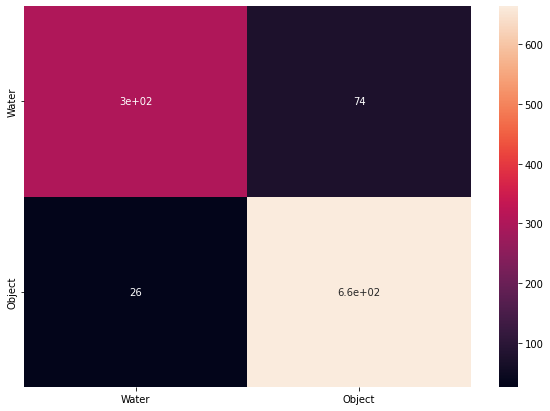

In [10]:
# confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
cm = confusion_matrix([np.argmax(a) for a in Y_test], [np.argmax(a) for a in Y_pred])

df_cm = pd.DataFrame(cm, index=["Water", "Object"], columns=["Water", "Object"])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)

In [11]:
def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset_raw.index(left_top_coord[0], left_top_coord[1])
    needles = []
    step_size = 15

    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)

    from matplotlib import pyplot as plt

    search_space = np.copy(img_raw[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    found = 0
    for i, result in enumerate(results):
        if result[1] > result[0]:
            found += 1
            coord = needles[i]
            xx, yy = dataset_raw.index(coord['lon'], coord['lat'])
            xx -= left_top_x
            yy -= left_top_y

            search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
            search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
            search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight

    print("found {} windmills".format(found))

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

found 53 windmills


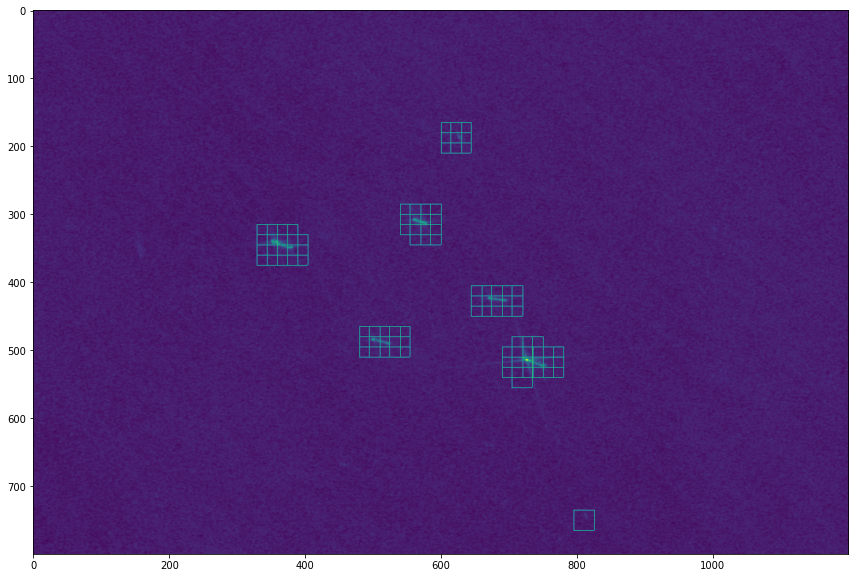

In [12]:
# vb boten
plot_windmills((7.67762,54.13169))

found 608 windmills


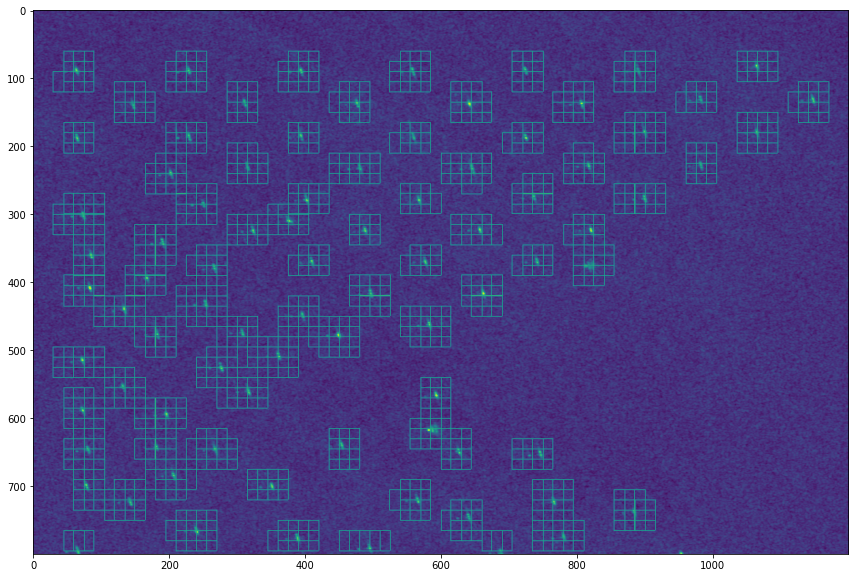

In [13]:
# vb molens
plot_windmills((6.93274,54.10366))

found 42 windmills


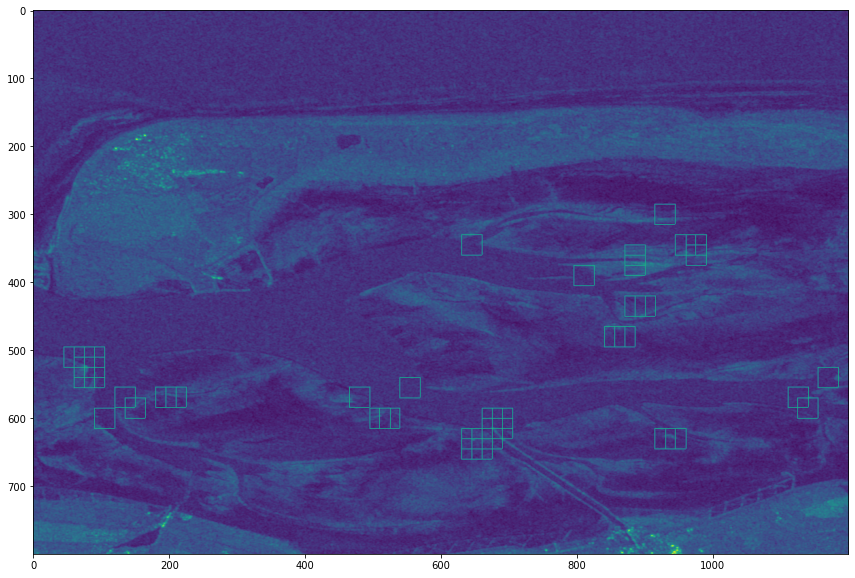

In [14]:
# vb kust
plot_windmills((7.46026,53.77598))

found 4060 windmills


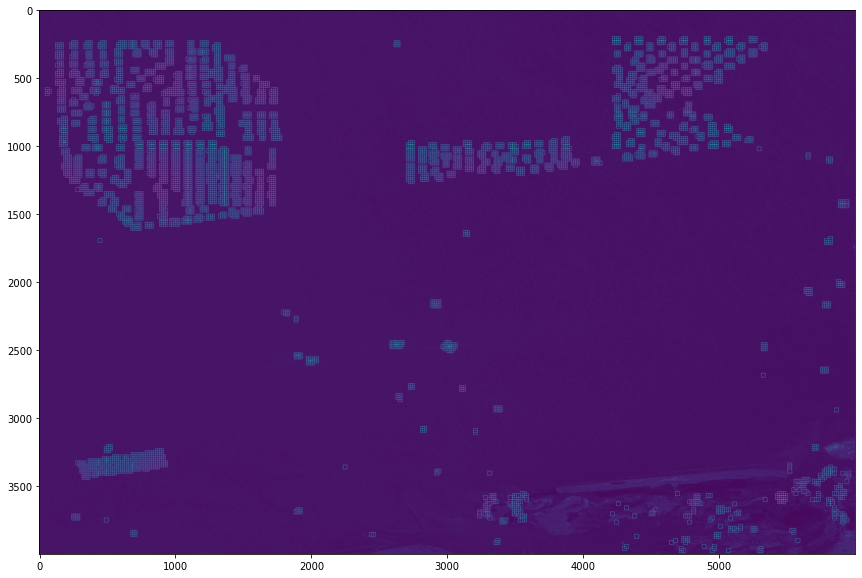

In [15]:
# het duurt redelijk lang voor dit te runnen
plot_windmills((6.39545,54.12086), (1200 * 5, 800 * 5), intensity=2)